In [ ]:
# clone the repository
!git clone https://github.com/TheoXiong7/CS445_FinalProject.git

# move the 'data' folder to the current directory
!mv CS445_FinalProject/data .

# cleanup
!rm -rf CS445_FinalProject

In [16]:
import torch
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

from style_transfer import stylize_image
from depth_aware_style_transfer import load_precomputed_masks, blend_stylized_layers, visualize_depth_layers
print('done')

done


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


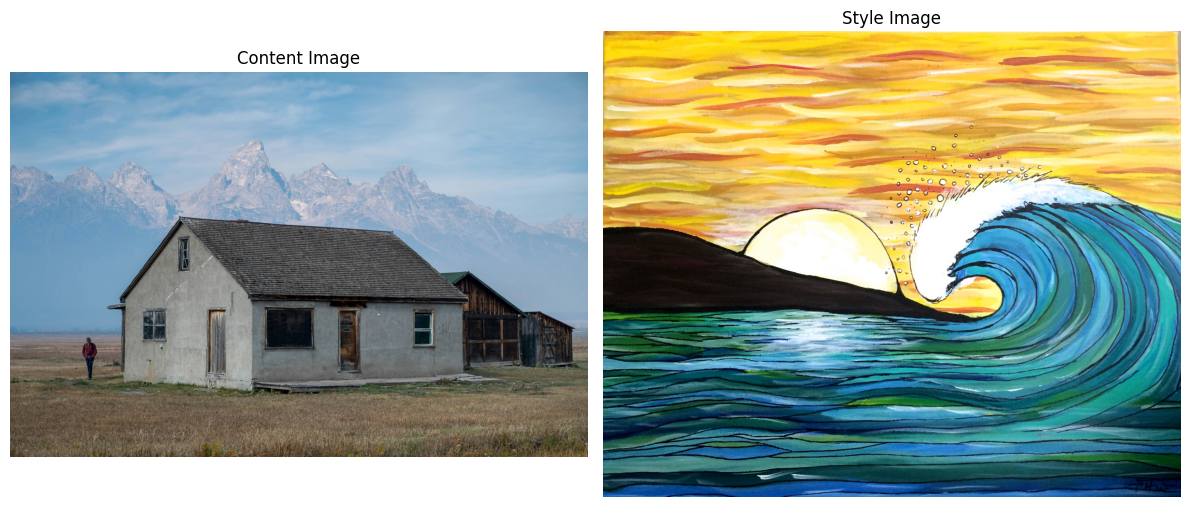

In [18]:
# load content & style
dataset_path = 'data'

content_name = 'house'
style_name = 'style_2'

content_path = os.path.join(dataset_path, 'images', f'{content_name}.jpg')
style_path = os.path.join(dataset_path, 'styles', f'{style_name}.jpg')

content_img = Image.open(content_path)
style_img = Image.open(style_path)

content_np = np.array(content_img)
output_size = 720
ratio = output_size / max(content_img.size)
new_h = int(content_img.size[1] * ratio)
new_w = int(content_img.size[0] * ratio)
target_shape = (new_h, new_w)

# load pre-computed masks for house.jpg
masks = load_precomputed_masks(
    mask_dir=os.path.join(dataset_path, 'masks'),
    image_name=content_name,
    target_shape=target_shape,
    feather_radius=15
)

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(content_img)
axes[0].set_title('Content Image')
axes[0].axis('off')
axes[1].imshow(style_img)
axes[1].set_title('Style Image')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# BASELINE
print("Running baseline style transfer...")
stylized_baseline = stylize_image(
    content_path=content_path,
    style_path=style_path,
    output_size=output_size,
    num_steps=300,
    style_weight=1e4,
    content_weight=1,
    verbose=True
)

# plot result
plt.figure(figsize=(10, 8))
plt.imshow(stylized_baseline)
plt.title('Stylized Image (Baseline)')
plt.axis('off')
plt.show()

In [ ]:
# DEPTH AWARE

# load pre-computed masks for house.jpg
masks = load_precomputed_masks(
    mask_dir=os.path.join(dataset_path, 'masks'),
    image_name='house',
    target_shape=target_shape,
    feather_radius=15
)

# resize content and stylized to target shape
content_resized = cv2.resize(content_np, (new_w, new_h))
if stylized_baseline.shape[:2] != (new_h, new_w):
    stylized_resized = cv2.resize(stylized_baseline, (new_w, new_h))
else:
    stylized_resized = stylized_baseline

# Blend with depth-aware style strengths
style_strengths = {
    'foreground': 0.3,
    'midground': 0.7,
    'background': 1.0
}

stylized_layers = {
    'foreground': stylized_resized,
    'midground': stylized_resized,
    'background': stylized_resized
}

stylized_depth = blend_stylized_layers(
    content_resized, stylized_layers, masks, style_strengths
)

# Create depth visualization (use masks to create a pseudo depth map)
depth_map = (masks['foreground'] * 1.0 +
             masks['midground'] * 0.5 +
             masks['background'] * 0.0)

vis = visualize_depth_layers(content_resized, depth_map, masks)

# plot result
plt.figure(figsize=(10, 8))
plt.imshow(stylized_depth)
plt.title('Stylized Image (Depth Aware)')
plt.axis('off')
plt.show()

# plot depth layers
plt.figure(figsize=(20, 5))
plt.imshow(vis)
plt.title('Depth Map | Foreground | Midground | Background')
plt.axis('off')
plt.show()

In [ ]:
# BATCH PROCESSING: All content images x all styles with pre-computed masks
import os
import glob
import time
from tqdm.notebook import tqdm
from depth_aware_style_transfer import (
    load_precomputed_masks,
    depth_aware_style_transfer_with_masks,
    blend_stylized_layers
)
from style_transfer import stylize_image

# Configuration
DATA_DIR = 'data'
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
STYLES_DIR = os.path.join(DATA_DIR, 'styles')
MASKS_DIR = os.path.join(DATA_DIR, 'masks')
RESULTS_DIR = 'results'

OUTPUT_SIZE = 512
NUM_STEPS = 200
STYLE_WEIGHT = 1e4
CONTENT_WEIGHT = 1
FEATHER_RADIUS = 15

STYLE_STRENGTHS = {
    'foreground': 0.3,
    'midground': 0.7,
    'background': 1.0
}

# Create results directory structure
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, 'baseline'), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, 'depth_aware'), exist_ok=True)

# Get all content images and styles
content_files = sorted(glob.glob(os.path.join(IMAGES_DIR, '*.jpg')) +
                       glob.glob(os.path.join(IMAGES_DIR, '*.png')))
style_files = sorted(glob.glob(os.path.join(STYLES_DIR, '*.jpg')) +
                     glob.glob(os.path.join(STYLES_DIR, '*.png')))

print(f"Found {len(content_files)} content images")
print(f"Found {len(style_files)} style images")
print(f"Total combinations: {len(content_files) * len(style_files)}")

# Preview what we're working with
if content_files:
    print(f"\nContent images: {[os.path.basename(f) for f in content_files[:5]]}...")
if style_files:
    print(f"Style images: {[os.path.basename(f) for f in style_files]}")

In [ ]:
# Run batch processing

def process_batch():
    """Process all content-style combinations."""
    results_log = []
    total = len(content_files) * len(style_files)

    if total == 0:
        print("No files to process! Make sure data/images/ and data/styles/ contain images.")
        return results_log

    start_time = time.time()

    with tqdm(total=total * 2, desc="Processing") as pbar:  # x2 for baseline + depth-aware
        for content_path in content_files:
            content_name = os.path.splitext(os.path.basename(content_path))[0]

            # Load content image to get target shape
            content_img = Image.open(content_path).convert('RGB')
            ratio = OUTPUT_SIZE / max(content_img.size)
            new_h = int(content_img.size[1] * ratio)
            new_w = int(content_img.size[0] * ratio)
            target_shape = (new_h, new_w)

            # Load pre-computed masks
            masks = load_precomputed_masks(
                MASKS_DIR,
                content_name,
                target_shape,
                feather_radius=FEATHER_RADIUS
            )

            for style_path in style_files:
                style_name = os.path.splitext(os.path.basename(style_path))[0]
                combo_name = f"{content_name}__{style_name}"

                # --- Baseline style transfer ---
                baseline_output = os.path.join(RESULTS_DIR, 'baseline', f"{combo_name}.jpg")
                try:
                    baseline = stylize_image(
                        content_path=content_path,
                        style_path=style_path,
                        output_size=OUTPUT_SIZE,
                        num_steps=NUM_STEPS,
                        style_weight=STYLE_WEIGHT,
                        content_weight=CONTENT_WEIGHT,
                        verbose=False
                    )
                    Image.fromarray(baseline).save(baseline_output, quality=95)
                    results_log.append({'type': 'baseline', 'file': combo_name, 'status': 'success'})
                except Exception as e:
                    results_log.append({'type': 'baseline', 'file': combo_name, 'status': f'error: {e}'})
                pbar.update(1)

                # --- Depth-aware style transfer ---
                depth_output = os.path.join(RESULTS_DIR, 'depth_aware', f"{combo_name}.jpg")
                try:
                    # Use same baseline result but blend with masks
                    content_np = np.array(content_img.resize((new_w, new_h), Image.LANCZOS))

                    # Resize baseline to match if needed
                    if baseline.shape[:2] != (new_h, new_w):
                        baseline_resized = cv2.resize(baseline, (new_w, new_h))
                    else:
                        baseline_resized = baseline

                    stylized_layers = {
                        'foreground': baseline_resized,
                        'midground': baseline_resized,
                        'background': baseline_resized
                    }

                    depth_aware = blend_stylized_layers(
                        content_np, stylized_layers, masks, STYLE_STRENGTHS
                    )
                    Image.fromarray(depth_aware).save(depth_output, quality=95)
                    results_log.append({'type': 'depth_aware', 'file': combo_name, 'status': 'success'})
                except Exception as e:
                    results_log.append({'type': 'depth_aware', 'file': combo_name, 'status': f'error: {e}'})
                pbar.update(1)

    elapsed = time.time() - start_time
    print(f"\nCompleted in {elapsed/60:.1f} minutes")
    print(f"Average time per image: {elapsed/total:.1f} seconds")

    # Summary
    successes = sum(1 for r in results_log if r['status'] == 'success')
    print(f"Success: {successes}/{len(results_log)}")

    return results_log

# Run the batch processing
results_log = process_batch()

In [ ]:
# Display sample results: Baseline vs Depth-Aware comparison

def show_comparison(content_name, style_name, figsize=(16, 5)):
    """Display original, baseline, and depth-aware results side by side."""
    combo_name = f"{content_name}__{style_name}"

    content_path = os.path.join(IMAGES_DIR, f"{content_name}.jpg")
    if not os.path.exists(content_path):
        content_path = os.path.join(IMAGES_DIR, f"{content_name}.png")

    style_path_full = os.path.join(STYLES_DIR, f"{style_name}.jpg")
    if not os.path.exists(style_path_full):
        style_path_full = os.path.join(STYLES_DIR, f"{style_name}.png")

    baseline_path = os.path.join(RESULTS_DIR, 'baseline', f"{combo_name}.jpg")
    depth_path = os.path.join(RESULTS_DIR, 'depth_aware', f"{combo_name}.jpg")

    fig, axes = plt.subplots(1, 4, figsize=figsize)

    # Original content
    if os.path.exists(content_path):
        axes[0].imshow(Image.open(content_path))
        axes[0].set_title('Content')
    axes[0].axis('off')

    # Style
    if os.path.exists(style_path_full):
        axes[1].imshow(Image.open(style_path_full))
        axes[1].set_title('Style')
    axes[1].axis('off')

    # Baseline
    if os.path.exists(baseline_path):
        axes[2].imshow(Image.open(baseline_path))
        axes[2].set_title('Baseline')
    else:
        axes[2].text(0.5, 0.5, 'Not found', ha='center', va='center')
    axes[2].axis('off')

    # Depth-aware
    if os.path.exists(depth_path):
        axes[3].imshow(Image.open(depth_path))
        axes[3].set_title('Depth-Aware')
    else:
        axes[3].text(0.5, 0.5, 'Not found', ha='center', va='center')
    axes[3].axis('off')

    plt.suptitle(f'{content_name} + {style_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Show a few sample comparisons
print("Sample Results:")

# Get first few content and style names
sample_contents = [os.path.splitext(os.path.basename(f))[0] for f in content_files[:3]]
sample_styles = [os.path.splitext(os.path.basename(f))[0] for f in style_files[:2]]

for content_name in sample_contents:
    for style_name in sample_styles:
        show_comparison(content_name, style_name)

In [ ]:
# =============================================================================
# RETRY FAILED COMBINATIONS
# =============================================================================

# Failed baseline: bridge3__style_1, living-room5__style_1
# Failed depth-aware: wildebeests__style_1 to style_5

failed_baseline = [
    ('bridge3', 'style_1'),
    ('living-room5', 'style_1'),
]

failed_depth_aware = [
    ('wildebeests', 'style_1'),
    ('wildebeests', 'style_2'),
    ('wildebeests', 'style_3'),
    ('wildebeests', 'style_4'),
    ('wildebeests', 'style_5'),
]

print("Retrying failed combinations...")

# Process failed baselines
for content_name, style_name in failed_baseline:
    print(f"\n[Baseline] {content_name} + {style_name}")
    
    content_path = os.path.join(IMAGES_DIR, f"{content_name}.jpg")
    style_path = os.path.join(STYLES_DIR, f"{style_name}.jpg")
    combo_name = f"{content_name}__{style_name}"
    output_path = os.path.join(RESULTS_DIR, 'baseline', f"{combo_name}.jpg")
    
    try:
        baseline = stylize_image(
            content_path=content_path,
            style_path=style_path,
            output_size=OUTPUT_SIZE,
            num_steps=NUM_STEPS,
            style_weight=STYLE_WEIGHT,
            content_weight=CONTENT_WEIGHT,
            verbose=True
        )
        Image.fromarray(baseline).save(output_path, quality=95)
        print(f"Saved: {output_path}")
        
        # Also generate depth-aware version
        content_img = Image.open(content_path).convert('RGB')
        ratio = OUTPUT_SIZE / max(content_img.size)
        new_h = int(content_img.size[1] * ratio)
        new_w = int(content_img.size[0] * ratio)
        
        masks = load_precomputed_masks(MASKS_DIR, content_name, (new_h, new_w), FEATHER_RADIUS)
        content_np = np.array(content_img.resize((new_w, new_h), Image.LANCZOS))
        
        if baseline.shape[:2] != (new_h, new_w):
            baseline_resized = cv2.resize(baseline, (new_w, new_h))
        else:
            baseline_resized = baseline
        
        stylized_layers = {'foreground': baseline_resized, 'midground': baseline_resized, 'background': baseline_resized}
        depth_aware = blend_stylized_layers(content_np, stylized_layers, masks, STYLE_STRENGTHS)
        
        depth_output = os.path.join(RESULTS_DIR, 'depth_aware', f"{combo_name}.jpg")
        Image.fromarray(depth_aware).save(depth_output, quality=95)
        print(f"Saved: {depth_output}")
        
    except Exception as e:
        print(f"Error: {e}")

# Process failed depth-aware (need to run baseline first for these)
for content_name, style_name in failed_depth_aware:
    print(f"\n[Depth-Aware] {content_name} + {style_name}")
    
    content_path = os.path.join(IMAGES_DIR, f"{content_name}.jpg")
    style_path = os.path.join(STYLES_DIR, f"{style_name}.jpg")
    combo_name = f"{content_name}__{style_name}"
    
    try:
        # Check if baseline exists, if not create it
        baseline_path = os.path.join(RESULTS_DIR, 'baseline', f"{combo_name}.jpg")
        if os.path.exists(baseline_path):
            baseline = np.array(Image.open(baseline_path))
            print("Using existing baseline")
        else:
            print("Running baseline first...")
            baseline = stylize_image(
                content_path=content_path,
                style_path=style_path,
                output_size=OUTPUT_SIZE,
                num_steps=NUM_STEPS,
                style_weight=STYLE_WEIGHT,
                content_weight=CONTENT_WEIGHT,
                verbose=True
            )
            Image.fromarray(baseline).save(baseline_path, quality=95)
        
        # Generate depth-aware
        content_img = Image.open(content_path).convert('RGB')
        ratio = OUTPUT_SIZE / max(content_img.size)
        new_h = int(content_img.size[1] * ratio)
        new_w = int(content_img.size[0] * ratio)
        
        masks = load_precomputed_masks(MASKS_DIR, content_name, (new_h, new_w), FEATHER_RADIUS)
        content_np = np.array(content_img.resize((new_w, new_h), Image.LANCZOS))
        
        if baseline.shape[:2] != (new_h, new_w):
            baseline_resized = cv2.resize(baseline, (new_w, new_h))
        else:
            baseline_resized = baseline
        
        stylized_layers = {'foreground': baseline_resized, 'midground': baseline_resized, 'background': baseline_resized}
        depth_aware = blend_stylized_layers(content_np, stylized_layers, masks, STYLE_STRENGTHS)
        
        depth_output = os.path.join(RESULTS_DIR, 'depth_aware', f"{combo_name}.jpg")
        Image.fromarray(depth_aware).save(depth_output, quality=95)
        print(f"Saved: {depth_output}")
        
    except Exception as e:
        print(f"Error: {e}")

print("\nDone retrying failed combinations!")

In [ ]:
# Download results as zip (for Colab)
import shutil

# Create zip file of results
zip_path = shutil.make_archive('results', 'zip', '.', 'results')
print(f"Created: {zip_path}")

# Download in Colab
try:
    from google.colab import files
    files.download('results.zip')
    print("Download started!")
except ImportError:
    print("Not running in Colab - zip file saved locally")